In [4]:
import rioxarray as rix
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

## Frequency map

In [5]:
frequency_map = xr.open_dataset('frequency_map.nc') 
# Should use xr.open_dataset() rather than rix.open_rasterio so that the longitude and latitude coords are preserved

In [19]:
frequency_map = frequency_map.rio.write_crs("EPSG:4326")

In [20]:
frequency_map.rio.crs

CRS.from_epsg(4326)

In [7]:
frequency_map

<xarray.Dataset>
Dimensions:       (longitude: 284, latitude: 284)
Coordinates:
  * longitude     (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0
  * latitude      (latitude) float64 49.0 48.99 48.98 ... 46.03 46.02 46.01
Data variables:
    fog_presence  (latitude, longitude) float64 ...

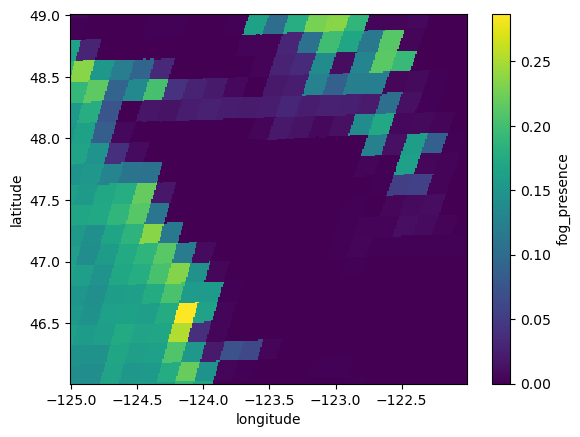

In [9]:
frequency_map['fog_presence'].plot()

In [10]:
bounds = frequency_map.rio.bounds()

In [11]:
import geopandas as gpd

In [12]:
shoreline = gpd.read_file("/storage/ngoc54n/us_medium_shoreline.shp")

In [13]:
shoreline["geometry"] = shoreline.clip_by_rect(*bounds)

In [14]:
shoreline = shoreline[~ shoreline["geometry"].is_empty]

Text(0.5, 1.0, 'Fog frequency map\nMay-September 2022\nGOES-17 Imagery')

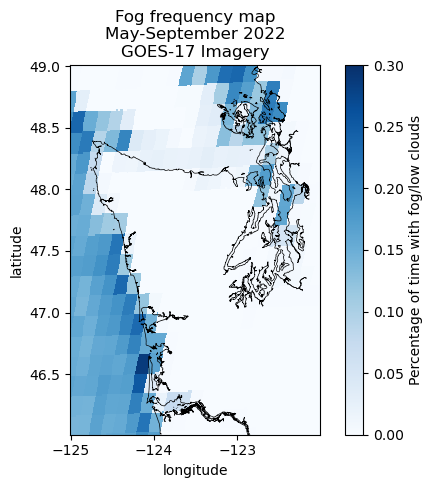

In [16]:
shoreline.plot(color = 'Black', linewidth=0.5)
frequency_map['fog_presence'].plot(
	cmap = "Blues", 
	cbar_kwargs={'label': "Percentage of time with fog/low clouds"},
	vmin=0,
	vmax=0.3
)
plt.title('Fog frequency map\nMay-September 2022\nGOES-17 Imagery')

## Time series for each location

In [72]:
def modify_xarray_timezone(ds, source_tz, target_tz):
    """Modify the timezone of an xr.Dataset. The dataset should have a coordinate and dimension 'time'.
    The returned xr.Dataset object will have the original 'time' coordinate/dimension overwritten.

    Args:
        ds (xr.Dataset): xarray Dataset object to have its time coordinate/dimension converted.
        source_tz (_type_): A pytz timezone object specifying the timezone the data is already in. 
                For example, `pytz.UTC`.
        target_tz (_type_): A pytz timezone object specifying the timezone the data is to be 
                converted to. For example, `pytz.timezone('US/Mountain')`.

    Returns:
        xr.Dataset: xarray Dataset with the time coordinate/dimension overwritten with the modified 
                timestamps.
    """
    ds = ds.copy()
    time_utc = ds['time'].to_index().tz_localize(source_tz)
    tz_corrected = time_utc.tz_convert(target_tz).tz_localize(None)
    local_da=xr.DataArray.from_series(tz_corrected)
    ds.coords.update({f'time ({target_tz})': tz_corrected})
    ds.coords.update({f'time ({source_tz})': ds['time'].to_index()})
    ds = ds.assign_coords({
        'time': ds[f'time ({target_tz})'].values
    })
    return ds


In [22]:
import xarray as xr
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd


In [64]:
megan = xr.open_dataset('megan_timeseries_0.nc') 
# Even though this and the frequency_map are both .nc files, frequency_map is 2D raster file with lat and lon, and this is a 1D array
megan

<xarray.Dataset>
Dimensions:    (time: 40785)
Coordinates:
    longitude  float64 ...
    latitude   float64 ...
  * time       (time) datetime64[ns] 2022-05-01T00:01:17 ... 2022-10-01T00:01:17
Data variables:
    HT         (time) float32 ...

In [73]:
# get the datetime information to add the our current dataset which has lost the minute information in the time coordinate after being processed by Dask
imageList = glob.glob('/storage/GOES/orthorectified/Fog2022_withtime/*_o.nc')
datetimes = sorted([datetime.strptime(i.split('_')[4][1:-3], "%Y%j%H%M") for i in imageList])

In [78]:
megan['time'] = datetimes
megan = modify_xarray_timezone(megan, 'UTC', 'US/Pacific')
megan['time'][0]

<xarray.DataArray 'time' ()>
array('2022-04-30T17:01:00.000000000', dtype='datetime64[ns]')
Coordinates:
    longitude          float64 ...
    latitude           float64 ...
    time               datetime64[ns] 2022-04-30T17:01:00
    time (US/Pacific)  datetime64[ns] 2022-04-30T17:01:00
    time (UTC)         datetime64[ns] 2022-05-01T00:01:00

In [79]:
megan['HT'].sel(time = slice("2022-07-14", "2022-07-14"))

<xarray.DataArray 'HT' (time: 288)>
[288 values with dtype=float32]
Coordinates:
    longitude          float64 ...
    latitude           float64 ...
  * time               (time) datetime64[ns] 2022-07-14T00:01:00 ... 2022-07-...
    time (US/Pacific)  (time) datetime64[ns] 2022-07-14T00:01:00 ... 2022-07-...
    time (UTC)         (time) datetime64[ns] 2022-07-14T07:01:00 ... 2022-07-...
Attributes:
    coordinates:   dem_px_angle_y dem_px_angle_x
    grid_mapping:  spatial_ref

Text(0.5, 1.0, "Time series of cloud at Megan's house")

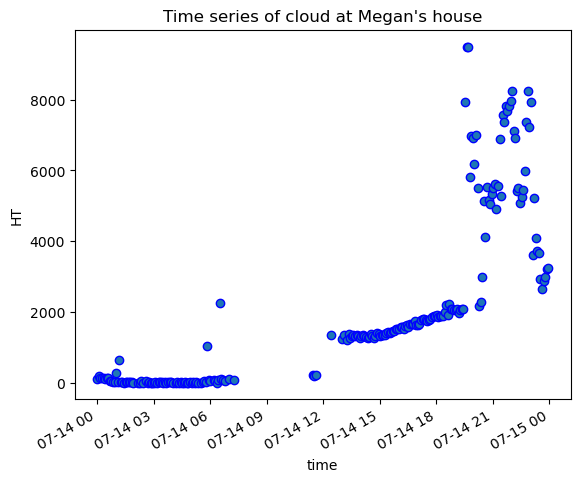

In [80]:
megan_timeseries = megan['HT'].sel(time = slice("2022-07-14", "2022-07-14"))
megan_timeseries.plot.scatter(edgecolors='Blue')
plt.title("Time series of cloud at Megan's house")

In [82]:
tide_df_1 = pd.read_csv("/storage/ngoc54n/FHL_tide_Jul2021-Jul2022.csv")

In [83]:
tide_df_1['datetime'] = tide_df_1[tide_df_1.columns[0:2]].apply(lambda x: ' '.join(x), axis=1)
tide_df_1['datetime'] = pd.to_datetime(tide_df_1['datetime'])
tide_df_1 = tide_df_1.set_index('datetime')
tide_df_1.index = tide_df_1.index.tz_localize('UTC').tz_convert('US/Pacific')
tide_df_1 = tide_df_1.loc["2022-07-14"]
tide_df_1.index[0]

Timestamp('2022-07-14 00:00:00-0700', tz='US/Pacific')

In [89]:
tide_df_1.index = tide_df_1.index.tz_localize(None)

Text(0.5, 1.0, "Megan's house")

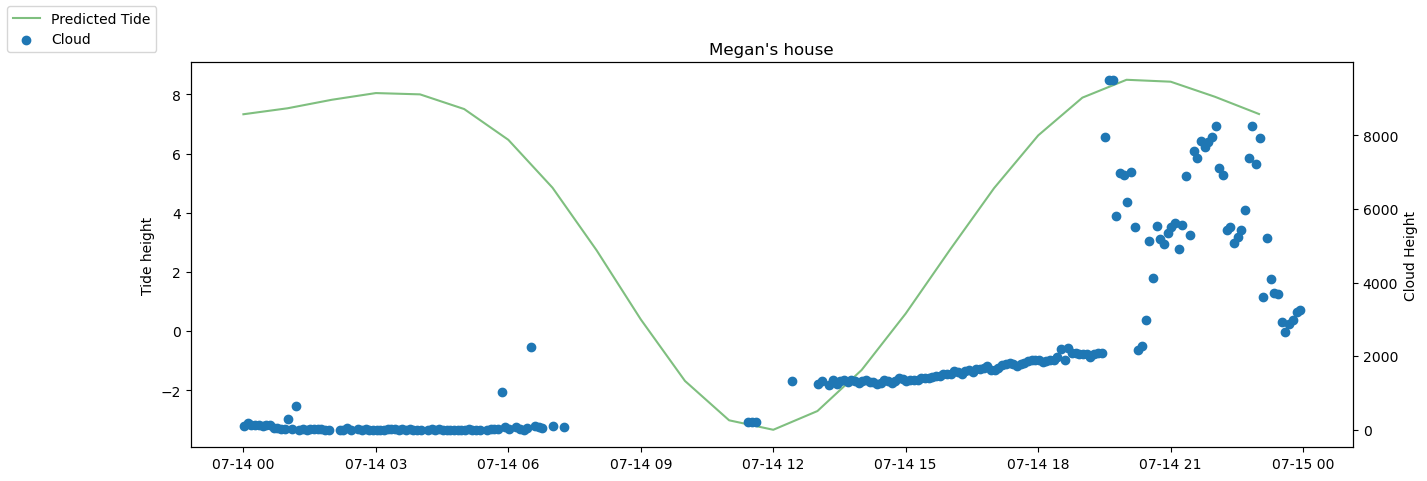

In [101]:
fig, ax1 = plt.subplots(figsize = (15,5))

ax_twin = ax1.twinx()
ax1.set_ylabel("Tide height")
ax_twin.set_ylabel("Cloud Height")

ax1.plot(tide_df_1.index, tide_df_1["Predicted (ft)"],color = "Green", alpha = 0.5, label = "Predicted Tide")
ax_twin.scatter(megan_timeseries['time'], megan_timeseries, marker = 'o', label = "Cloud")

fig.legend(loc = 'upper left')
# ax_twin.legend(loc = 'upper right')

plt.title("Megan's house")



In [ ]:
# convert megan to a pandas dataframe with localized time index
